[0.63732403 0.0709359  0.27856818]
[0.99831818 0.78115109 0.36778114]
[0.88837208 0.72170094 0.70818942]


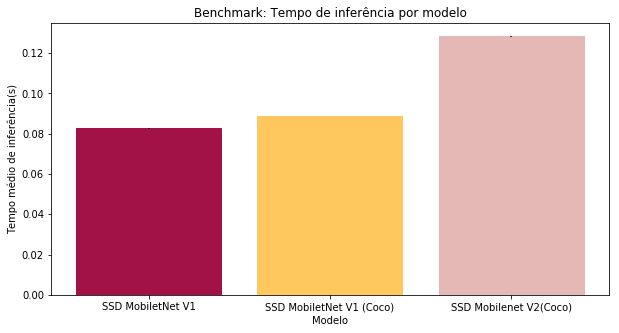

In [22]:
import os
import numpy as np
import glob
import scipy.stats as st
import math
import matplotlib.pyplot as plt
import cv2
import video_detection as vd
import json


def conf_inter(sample, interval):
    avg = np.average(sample)
    std = st.sem(sample)
    conf = st.norm.interval(interval, loc=np.average(sample), scale=st.sem(sample)/math.sqrt(len(sample)))
    return conf

def collect_metrics(models):
    files = glob.glob('*.dat')
    files.sort()
    metrics = np.zeros(shape=(len(models), 4))

    for i, file in enumerate(files):
        with open(file,'r') as f:
            data = f.read()
            measurements = np.array(data.split('\n'))
            measurements = measurements[measurements != ''].astype(np.float32)
            avg = np.average(measurements)
            std = st.sem(measurements)
            conf = conf_inter(measurements, 0.95)
            metrics[i,:] = [avg, std, conf[0], conf[1]]
    return metrics


def plot_time_bars(models, averages, errors, colors=None):
    fig, axis = plt.subplots(1, 1, figsize=(10, 5))
    axis.set_title('Benchmark: Tempo de inferência por modelo')
    axis.set_ylabel('Tempo médio de inferência(s)')
    axis.set_xlabel('Modelo')
    bars = axis.bar(models, averages, yerr=errors)
    if(colors == None):
        for bar in bars:
            color = np.random.rand(3)
            print(color)
            bar.set_color(color)
    else:
        for bar, color in zip(bars, colors):
            bar.set_color(color)

    if(os.path.exists('charts/bar.jpg')):
        os.remove('charts/bar.jpg')
    plt.savefig('charts/bar.jpg')

models = ['SSD MobiletNet V1', 'SSD MobiletNet V1 (Coco)', 'SSD Mobilenet V2(Coco)']
metrics = collect_metrics(models)
averages = metrics[:,0]
stds = metrics[:, 1]
errors = averages-metrics[:,2]

plot_time_bars(models, averages, errors)


In [ ]:
model_nums = [0]

for model_num in model_nums:
    model = vd.load_net(2)
    #print(model)
    #print(classes[0:5])
    #print(os.listdir('./dataset/val2017/')[0:3])

    for i, image_file in enumerate(os.listdir('./dataset/val2017/')):
        #print(image_file)
        image = cv2.imread('dataset/val2017/'+image_file)
        #fig, axis = plt.subplots()

        bounding_boxes, class_indexes, confidences, elapsed = vd.detect(model, image)
        #for box, class_index, confidence in zip(bounding_boxes, class_indexes, confidences):
        #    vd.draw_boxes(model, image, box, class_index, confidence)


        detections = []
        for bounding_box, class_index, confidence in zip(bounding_boxes, class_indexes, confidences):
            start_x, start_y, end_x, end_y = bounding_box
            start_x = int(start_x)
            start_y = int(start_y)
            w = int(end_x - start_x)
            h = int(end_y - start_y)
            confidence = float(confidence)
            image_id = image_file.strip('0')[:image_file.rfind('.')]
            #print('confidence', type(confidence))
            #print('class index', type(class_index))
            #print('start x', type(start_x))
            #print('image id', type(image_file.strip('0')[:image_file.rfind('.')]))
            detection = {
                'image_id': image_id,
                'category_id': class_index,
                'bbox': [start_x, start_y, w, h],
                'score': confidence
            }
            #print(detection)
            #print('\n\n')
            detections.append(detection)
        if(i % 500 == 0):
            print(i)

    output_file = 'benchmark/detections_{}.json'.format(model_num)
    if(os.path.exists(output_file)):
        os.remove(output_file)

    with open(output_file, 'wt') as f:
        json.dump(detections, f)
        print('pronto')
    
    

0
0
500
500
500
500
500
500
500
500


In [39]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

result_files = ['benchmark/detections_{}.json'.format(i) for i in range(0)]

annotations = 'validation/val2017/instances_val2017.json'
coco_gt = COCO(annotations)

annotation_types = ['category_id']

for file in files:
    print('file', file)
    dataset = coco_gt.loadRes(file)
    coco_eval = COCOeval(coco_gt, dataset, annotation_types)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
#dataset = coco_dataset()

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
file benchmark/detections_0.json
Loading and preparing results...


AssertionError: Results do not correspond to current coco set

<h2>Introdução</h2>
<p>Este trabalho tem o propósito de realizar a comparação quantitativa de modelos de aprendizado de máquina voltados à detecção de objetos em imagens. Houve interesse, sobretudo, em estudar a aplicabilidade destes modelos em circunstâncias que  imponham limitações ao hardware utilizado, como em computadores pessoais de baixo custo.</p>
<p>Com tal finalidade, foram selecionados modelos baseados em técnicas Deep Learning, </p>
    
    
    
    
    realizados testes que permitem a extração de métricas de desempenho

<h2>Metodologia</h2>
<p>Os testes foram </p>